# A Simple MLP

In [1]:
# mlp for multi-output regression
import time
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *
from keras import Input
from keras.callbacks import CSVLogger, EarlyStopping

from scipy import signal

In [2]:
xls_train = pd.ExcelFile('./data/train_3.xlsx')
xls_test = pd.ExcelFile('./data/test_3.xlsx')

In [3]:
def norm_data(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    data = (data - mean)/std
    
    return data, mean, std

def preprocess_data(sheet):

    # Normalize sensor readings
    sheet[['1','2','3','4']] = sheet[['1','2','3','4']] 
    
    # Start from (0,0) position
    sheet['x'] = sheet['x'] - sheet['x'][0]
    sheet['y'] = sheet['y'] - sheet['y'][0]
    # Combine F and B, L and R
    sheet['F'] = sheet['F'] - sheet['B']
    sheet['L'] = sheet['L'] - sheet['R']
    
    # Down-sampling by moving average
    new_data = sheet.values
    new_data = signal.decimate(new_data, 10, axis=0)
    new_data = signal.decimate(new_data, 10, axis=0)
    # new_data = signal.decimate(new_data, 2, axis=0)
    
    return new_data

def augment_data(data):
    start_idx = int(data.shape[0]/2)
    data_repeat = data[start_idx:]
    for i in range(10):
        data = np.concatenate((data, data_repeat), axis=0)
    
    return data

def load_data(xls, features_all):
    df = pd.read_excel(xls, sheet_name=None)
    print("Read {} sheets from excel file".format(len(df)))
    
    new_df = pd.DataFrame()
    for sheet in df.values():
        sheet.columns = features_all
        new_data = preprocess_data(sheet)
        # new_data = augment_data(new_data)
        new_sheet = pd.DataFrame(new_data, columns = features_all)
        new_df = pd.concat([new_df, new_sheet])
        
    new_df.drop(['time','B','R'], axis=1, inplace=True)
    print("DataFrame Shape: {} rows, {} columns".format(*new_df.shape))
    display(new_df.head())
    
    X = new_df[features_considered].values
    y = new_df[outputs_considered].values
    
    print(X.shape, y.shape)
    
    return X, y, mean, std

In [4]:
features_all = ['t','1','2','3','4','F','B','L','R','time','x','y']
features_considered = ['t','1','2','3','4','F','L']
# features_considered = ['t','1','2','3','4']
# features_considered = ['t','F','L']
outputs_considered = features_all[-2:]

# load train dataset
X_train, y_train, mean_train, std_train = load_data(xls_train, features_all)
print('Train data loaded')
# load test dataset
X_test, y_test, mean_test, std_test = load_data(xls_test, features_all)
print('Test data loaded')

Read 38 sheets from excel file
DataFrame Shape: 7415 rows, 9 columns


,t,1,2,3,4,F,L,x,y
0,-0.012081,65.766778,73.779661,112.672102,98.700962,0.977237,-3.010781e-20,0.139343,0.012577
1,0.983315,219.783380,215.927515,104.664573,98.700961,0.977237,3.091346e-20,0.841346,-1.164877
2,1.960380,197.544185,188.543886,103.292648,98.700961,0.977237,-2.138276e-20,0.646198,-1.053562
3,2.936302,211.922904,200.065832,101.655321,98.700961,0.977237,2.986297e-22,0.487545,-1.105296
4,3.923101,199.799120,185.897688,100.883238,98.700961,0.977237,3.009279e-20,0.483376,-1.171681


(7415, 7) (7415, 2)
Train data loaded
Read 6 sheets from excel file
DataFrame Shape: 1300 rows, 9 columns


,t,1,2,3,4,F,L,x,y
0,-0.012081,145.507484,99.207522,93.613624,98.700961,0.977237,0.0,0.069623,0.013449
1,0.983315,276.976917,228.863620,94.882731,98.700961,0.977237,0.0,0.248148,-0.722414
2,1.960380,248.278863,202.233117,93.879449,98.700961,0.977237,0.0,0.229286,-0.669523
3,2.936302,257.712106,216.910136,93.217687,98.700961,0.977237,0.0,0.115015,-0.633417
4,3.923101,246.866819,194.655958,93.379387,98.700961,0.977237,0.0,0.302241,-0.651253


(1300, 7) (1300, 2)
Test data loaded


In [5]:
# We use "lr_schedule" to see which "learning rate" is optimum 
# Run the model with less epoch to visualize "learning rate" vs "loss"
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#                     lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
# loss = tf.keras.losses.Huber()
# optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# optimizer = 'adam'

# get the model
def get_model(n_inputs, n_outputs, optimizer):
    model = Sequential()
    model.add(Input(shape=(n_inputs,)))
    model.add(BatchNormalization(name = 'batch_norm_0'))
    model.add(Dense(16, name = 'dense_1', kernel_initializer='he_uniform', activation='relu'))
    model.add(BatchNormalization(name = 'batch_norm_1'))
    # model.add(Dense(32, name = 'dense_2', kernel_initializer='he_uniform', activation='relu'))
    # model.add(BatchNormalization(name = 'batch_norm_2'))
    # model.add(Dense(64, name = 'dense_3', kernel_initializer='he_uniform', activation='relu'))
    # model.add(BatchNormalization(name = 'batch_norm_3'))
    # model.add(Dense(32, name = 'dense_4', kernel_initializer='he_uniform', activation='relu'))
    # model.add(BatchNormalization(name = 'batch_norm_4'))
    model.add(Dense(16, name = 'dense_5', kernel_initializer='he_uniform', activation='relu'))
    model.add(BatchNormalization(name = 'batch_norm_5'))
    model.add(Dense(8, name = 'dense_6', kernel_initializer='he_uniform', activation='relu'))
    model.add(BatchNormalization(name = 'batch_norm_6'))
    model.add(Dense(n_outputs, name = 'dense_7'))
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    # model = Sequential()
    # model.add(Input(shape=(n_inputs,)))
    # model.add(BatchNormalization(name = 'batch_norm_0'))
    # model.add(Dense(16, name = 'dense_1', kernel_initializer='he_uniform', activation='relu'))
    # model.add(Dropout(0.30, name = 'dropout_1'))
    # model.add(BatchNormalization(name = 'batch_norm_1'))
    # model.add(Dense(64, name = 'dense_2', kernel_initializer='he_uniform', activation='relu'))
    # model.add(Dropout(0.20, name = 'dropout_2'))
    # model.add(BatchNormalization(name = 'batch_norm_2'))
    # model.add(Dense(128, name = 'dense_3', kernel_initializer='he_uniform', activation='relu'))
    # model.add(Dropout(0.20, name = 'dropout_3'))
    # model.add(BatchNormalization(name = 'batch_norm_3'))
    # model.add(Dense(64, name = 'dense_4', kernel_initializer='he_uniform', activation='relu'))
    # model.add(Dropout(0.20, name = 'dropout_4'))
    # model.add(BatchNormalization(name = 'batch_norm_4'))
    # model.add(Dense(16, name = 'dense_5', kernel_initializer='he_uniform', activation='relu'))
    # model.add(BatchNormalization(name = 'batch_norm_5'))
    # model.add(Dense(n_outputs, name = 'dense_6'))
    # model.compile(loss = "mse", optimizer=optimizer, metrics = ['mae', 'mse'])
    
    return model

In [6]:
EPOCHS = 1
BATCH_SIZE = 128

# define model
optimizer = 'adam'
# optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]
model = get_model(n_inputs, n_outputs, optimizer)
print(model.summary())

# Train
# print("\nTRAIN MODEL...")
modelstart = time.time()

# model.fit(X_train, y_train, epochs=EPOCHS, verbose=1)
# history = model.fit(train_data, epochs=EPOCHS, validation_data=test_data, verbose=1)

results = list()
rkf = RepeatedKFold(n_splits=4, n_repeats=8, random_state=1)
for train_ix, test_ix in rkf.split(X_train):
    ix_range = X_train.shape[0]
    train_ix = train_ix[train_ix < ix_range]
    test_ix = test_ix[test_ix < ix_range]
    print("Filtered: TRAIN:", train_ix.shape, "TEST:", test_ix.shape)
    # prepare data
    X_train_, X_test_ = X_train[train_ix], X_train[test_ix]
    y_train_, y_test_ = y_train[train_ix], y_train[test_ix]
    
    # fit model
    model.fit(X_train_, y_train_, verbose=1, epochs=EPOCHS)
    # evaluate model on test set
    mse = model.evaluate(X_test_, y_test_, verbose=1)
    # store result
    # print('iteration %d: MSE = %.3f' %(len(results), mse))
    results.append(mse)

print('MSE: %.3f (%.3f)' % (mean(results), std(results))) 

print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
model.save('mlp_full_train.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 7)                 28        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                128       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_norm_5 (BatchNormaliza (None, 16)                64        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
batch_norm_6 (BatchNormaliza (None, 8)                 3

In [7]:
def plot_test_results(name, t, y_pred, y_test):
    
    FDE = np.linalg.norm(y_pred[-1,:] - y_test[-1,:])
    print("Sheet No.", name)
    print("FDE =", FDE)
    
    plt.figure(figsize=(6, 6))
    # plt.plot(np.array(y_pred[:,0]), np.array(y_pred[:,1]), 'r', label='predicted')
    # plt.plot(np.array(y_test[:,0]), np.array(y_test[:,1]), 'g', label='real')
    plt.plot(t, y_pred[:,0], 'r', label='predicted x')
    plt.plot(t, y_pred[:,1], 'b', label='predicted y')
    plt.plot(t, y_test[:,0], 'g', label='real x')
    plt.plot(t, y_test[:,1], 'c', label='real y')
    plt.legend(loc='upper left')
    plt.show()
    
    return

Read 1 sheets from excel file
DataFrame Shape: 29000 rows, 12 columns
Sheet No. 8
FDE = 2.188360772837085


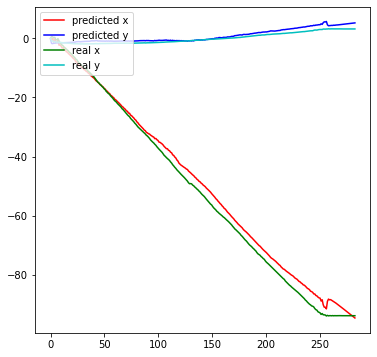

<ipython-input-8-cb7416a2ef80>:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  combined = np.concatenate([t[:, np.newaxis], y_test, y_pred], axis = 1)


In [8]:
# Load test data
xls_train = pd.ExcelFile('./data/train_3.xlsx')
# xls_test = pd.ExcelFile('./data/test_3.xlsx')
xls_test = pd.ExcelFile('./data/8.xlsx')
df_test = pd.read_excel(xls_test, sheet_name=None)
print("Read {} sheets from excel file".format(len(df_test)))

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./data/8_test_all.xlsx', engine='openpyxl')

for name, sheet in zip(df_test.keys(), df_test.values()):
    print("DataFrame Shape: {} rows, {} columns".format(*sheet.shape))
    sheet.columns = features_all
    new_data = preprocess_data(sheet)
    new_sheet = pd.DataFrame(new_data, columns = features_all)
    
    t = new_sheet['t']
    X_test = new_sheet[features_considered].values
    y_test = new_sheet[outputs_considered].values
    
    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    plot_test_results(name, t, y_pred, y_test)
    
    combined = np.concatenate([t[:, np.newaxis], y_test, y_pred], axis = 1)
    df = pd.DataFrame(combined, columns = ['t', 'real_x', 'real_y', 'pred_x', 'pred_y'])
    df.to_excel(writer, index=False, sheet_name=name)
    
# Close the Pandas Excel writer and output the Excel file.
writer.save()